<h1>Group 38 Project Proposal: Determining the Connection Between Country Wealth and Tuberculosis Mortality <h1>
    
<img src="images/TB_img.jpg" alt="Tuberculosis under EM Microscope" width = "1000"/>
    
<font size="2"> <i>image attribution</i>: NIAID Mycobacterium tuberculosis Bacteria, the Cause of TB, CC BY 2.0 <https://creativecommons.org/licenses/by/4.0>, via Flickr at <https://www.flickr.com/photos/niaid/51637606937/in/photostream/> </font>

<h3>Introduction</h3>
<hr>

*Total Word Count:* ---

Tuberculosis is an airborne respiratory disease that affects mainly the lungs. It can also affect other organs and the symptoms differ depending on where the infection is. Tuberculosis is spread by germs that are released into the air when someone coughs or sneezes. People who breathe in this air may not necessarily become sick because the germs are not active, although they may become sick later on. When the germs are active they divide and attack organ tissues, causing severe threats.  
HIV (Human Immunodeficiency Virus) is an infection that affects the immune system. Symptoms include flu-like symptoms, chills, rash, and fatigue. HIV spreads through sex and sharing needles. More serious stages of HIV develop into AIDS (Acquired immunodeficiency syndrome). There’s currently no cure or vaccine for HIV. 
Due to a decrease in the functionality of the immune system in HIV patients, they are more likely to become sick with other diseases, especially tuberculosis. 

Preventive measures and access to healthcare services are of utmost importance when it comes to reducing these infections in the population. However, these factors are not always accessible in every part of the world. In this observational study, we aim to compare the number of deaths due to Tuberculosis across countries in different World Bank income groups, specifically between low-income countries and high-income countries. By doing this we can make conclusions about how much a country invests in healthcare can affect accessibility and the deaths caused by diseases such as Tuberculosis. 
The dataset that we are using is “Tuberculosis > Mortality Data by Country” (source: https://apps.who.int/gho/data/view.main.57020ALL?lang=en)
The data file is xmart.csv

**The columns in the full dataset are: **  
**Country**  
**Year**  
**Number of deaths due to tuberculosis, excluding HIV**: number of deaths caused by tuberculosis in a given year, rounded to 2 significant figures  
**Deaths due to tuberculosis among HIV-negative people (per 100 000 population)**: number of deaths caused by tuberculosis that have been tested negative for HIV in a given year



<h3>Research Question</h3>
<hr>
We aim to compare the mean Tuberculosis deaths of countries with higher GDP vs countries with lower GDP. This will provide an insight into the impact of financial infrastructure and healthcare accessibility on mortality when infected with Tuberculosis.

<h3>Preliminary Results</h3>
<hr>

In [286]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
library(gridExtra)
library(readxl)
options(repr.matrix.max.rows = 6)
options(repr.matrix.max.cols = 3)

For this investigation, we use two datasets: the **World Health Orginization (WHO)** Tuberculosis Mortality dataset, and the **OECD** GDP by country dataset.

We begin with the **WHO** dataset, which we'll wrangle into tidy data before encorperating the **OECD** GDP data.

In [289]:
# URL of the WHO dataset csv file
# tb_url <- "https://github.com/Remembria/Group-38-Project-Proposal/raw/main/xmart.csv"
tb_url <- "https://apps.who.int/gho/athena/data/xmart.csv?target=GHO/MDG_0000000017,TB_e_mort_exc_tbhiv_num&profile=crosstable&filter=COUNTRY:*;REGION:*&ead=&x-sideaxis=COUNTRY;YEAR&x-topaxis=GHO"
# Reading this csv file into a dataframe
tb_df <- read.csv(tb_url)

head(tb_df)

,Country,Year,⋯,Deaths.due.to.tuberculosis.among.HIV.negative.people..per.100.000.population.
,<chr>,<int>,⋯,<chr>
1,Afghanistan,2021,⋯,31 [18-47]
2,Afghanistan,2020,⋯,34 [20-52]
3,Afghanistan,2019,⋯,26 [15-39]
4,Afghanistan,2018,⋯,29 [17-44]
5,Afghanistan,2017,⋯,30 [18-45]
6,Afghanistan,2016,⋯,34 [20-51]


As of now, however, this dataset is unprocessed, and contains unnecessary error bars. We fix this with a series of operations to wrangle our data into three columns: *Country*, *Year*, and *Deaths due to TB per 100,000*, taking data exclusively from 2020 to reflect the current GDP based tuberculosis mortality trends.

In [290]:
#Rename the data columns so we can easily work with them 
tb_df <- tb_df %>%
    # Selecting the columns of interest
    select(Country, Year, Deaths.due.to.tuberculosis.among.HIV.negative.people..per.100.000.population.) %>%
    # Renaming columns to improve readability 
    rename(Deaths_due_to_TB_per_100_000 = Deaths.due.to.tuberculosis.among.HIV.negative.people..per.100.000.population.) %>%
    # Setting the year to 2020
    filter(Year == 2020) %>%
    # Removing the Year column now that 2020 has been selected
    select(-Year)

To remove the error bars, we use REGEX and the str_remove function, converting the column's data type to double in the process

In [291]:
tb_df <- tb_df %>%
    # Removing all error bars with " \\[.*\\]" in regex, and all spaces with str_remove_all(..., " ")
    mutate(Deaths_due_to_TB_per_100_000 = str_remove_all(str_remove(Deaths_due_to_TB_per_100_000, " \\[.*\\]"), " ")) %>%
    # Converting the column to be of type double
    mutate(Deaths_due_to_TB_per_100_000 = as.double(Deaths_due_to_TB_per_100_000)) %>%
    # NA values removed for safety
    filter(!is.na(Deaths_due_to_TB_per_100_000))
tb_df

Country,Deaths_due_to_TB_per_100_000
<chr>,<dbl>
Afghanistan,34.00
Albania,0.32
Algeria,9.00
⋮,⋮
Yemen,9.5
Zambia,32.0
Zimbabwe,12.0


We will now begin our next phase of the wrangling process - importing the HDI database.


For the purposes of this investigation, following the classification of the United Nations Development Reports (UNDP), we consider a high HDI to be values **>0.700**, and low to be HDI values **<0.550**

In [292]:
# URL of the UNDP HDI Dataset
hdi_url <- "https://hdr.undp.org/sites/default/files/2021-22_HDR/HDR21-22_Statistical_Annex_HDI_Trends_Table.xlsx"
# We download this dataset first as read_excel works with local files
download.file(hdi_url, destfile = "HDI_Global_Database.xlsx") 

# SuppressMessages used here to prevent read_excel from printing every column in sets to a default name 
suppressMessages(
hdi_df <- read_excel("HDI_Global_Database.xlsx", sheet = 1, col_names = TRUE))

# Make.names removes the spaces from the column names 
names(hdi_df) = make.names(names(hdi_df))

hdi_df <- hdi_df %>%
    #Here we select the two columns of interest
    select("Table.2..Human.Development.Index.trends..1990.2021", "...15") %>%
    #To make them easier to work with, we rename them to Country and HDI
    rename("Country" = "Table.2..Human.Development.Index.trends..1990.2021" , "HDI" = "...15") %>%
    #Turning the type of HDI from <chr> to <dbl>
    mutate(HDI = as.double(HDI)) %>%
    #Removing NA values
    filter(!is.na(HDI))
    
# Because this data formats poorly (due to spacings added for visual aesthetic in the .xlsx file), 
# we remove non-relevant data columns here to fix this issue
hdi_df = hdi_df[-c(1, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210),]
hdi_df

Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Country,HDI
<chr>,<dbl>
Switzerland,0.956
Norway,0.959
Iceland,0.957
⋮,⋮
Niger,0.401
Chad,0.397
South Sudan,0.386


Before we merge these two datasets, however, there is one large problem - naming conventions. Different databases use different names for certain countries *(e.g. Democratic Republic of Congo vs Congo (Democratic Republic of))*, which prevents us from merging immediately

To get a picture of what names are different, we call R's setdiff function on the two Country columns

In [293]:
setdiff(tb_df$Country, hdi_df$Country)

[1] "Cook Islands"                                        
 [2] "Democratic Republic of the Congo"                    
 [3] "Eswatini"                                            
 [4] "Monaco"                                              
 [5] "Nauru"                                               
 [6] "Niue"                                                
 [7] "Republic of Korea"                                   
 [8] "Republic of Moldova"                                 
 [9] "Somalia"                                             
[10] "United Kingdom of Great Britain and Northern Ireland"
[11] "United Republic of Tanzania"                         
[12] "United States of America"

We solve this using a simple case_when function, which replaces the names used in the OECD HDI dataset with those used by WHO in the tuberculosis dataframe. Countries unaccounted for in the case_when function below are those for which HDI data is not available.

In [294]:
hdi_df <- hdi_df %>%
    mutate(Country = case_when(Country == "Congo (Democratic Republic of the)" ~ "Democratic Republic of the Congo",
                                  Country == "Eswatini (Kingdom of)" ~ "Eswatini",
                                  Country == "Korea (Republic of)" ~ "Republic of Korea",
                                  Country == "Moldova (Republic of)" ~ "Republic of Moldova",
                                  Country == "United Kingdom" ~ "United Kingdom of Great Britain and Northern Ireland",
                                  Country == "Tanzania (United Republic of)" ~ "United Republic of Tanzania",
                                  Country == "United States" ~ "United States of America",
                                  TRUE ~ Country))

We now merge the two datasets, grouping the HDI values into low (<0.550), and high (>0.700) values accordingly

In [303]:
tb_hdi_df <- tb_df %>%
    merge(hdi_df,by = "Country", all.x = FALSE) %>%
    filter(HDI > 0.700 | HDI < 0.550) %>%
    mutate(HDI = ifelse(HDI > 0.700, "High", "Low")) %>%
    rename("HDI_Classification" = "HDI")
 

tb_hdi_df

Country,Deaths_due_to_TB_per_100_000,HDI_Classification
<chr>,<dbl>,<chr>
Afghanistan,34.00,Low
Albania,0.32,High
Algeria,9.00,High
⋮,⋮,⋮
Uzbekistan,3.2,High
Viet Nam,8.9,High
Yemen,9.5,Low


We compare these two distributions subsequently with a boxplot

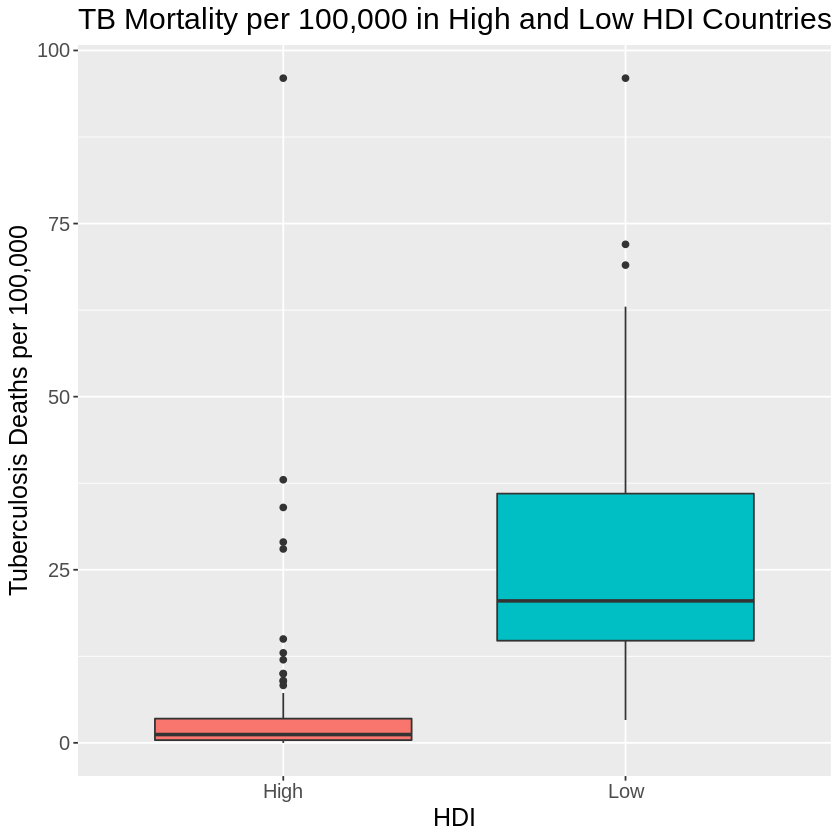

In [310]:
hdi_tb_boxplot <-
    tb_hdi_df %>% 
    ggplot() +
    geom_boxplot(aes(x = HDI_Classification, y = Deaths_due_to_TB_per_100_000, fill = HDI_Classification)) +
    theme(text = element_text(size = 15)) +
    ggtitle("TB Mortality per 100,000 in High and Low HDI Countries") + 
    xlab("HDI") + 
    ylab("Tuberculosis Deaths per 100,000") + 
    guides(fill = "none")

hdi_tb_boxplot

<h3>Methods: Plan</h3>
<hr>

**Overview:**  
Our report provides valuable insights into the relationship between two deadly diseases, HIV and TB, and highlights the impact of financial infrastructure on the prevalence of these diseases in different countries. By utilizing data from a trusted source such as the World Health Organization's Global Health Observatory, our study's findings are reliable and credible.  
In addition, our study employs rigorous research methods to analyze and interpret the data, ensuring that the findings are robust and credible. Our report's methodology and analytical techniques are transparent, making it possible for others to replicate our study and validate the results.  
Finally, our report is transparent about any limitations or potential sources of bias in the data or methodology, providing readers with a clear understanding of the study's strengths and weaknesses. This transparency adds to the report's credibility and enhances its value as a resource for healthcare policymakers, practitioners, and researchers.

**Expected Findings**  
We expect to find a higher incidence of tuberculosis (TB) among HIV-negative patients in third-world nations and countries with inadequate healthcare infrastructure. This is because TB is more prevalent in such areas due to various factors such as poverty, malnutrition, overcrowding, and weak healthcare systems. In addition, individuals living with HIV are more susceptible to contracting TB due to their weakened immune systems. As a result, our study may reveal a significant association between the country of residence and TB prevalence among HIV-negative patients, highlighting the need for improved healthcare infrastructure in these regions to reduce the burden of TB.


**Impacts**  
Tuberculosis is one of the top 10 causes of death worldwide, and it disproportionately affects people in low and middle-income countries. By shedding light on the link between HIV-negative status, country of residence, and tuberculosis prevalence, our study could help policymakers and healthcare providers understand the need for targeted interventions to reduce the incidence of TB in these areas. This could include initiatives such as improved diagnostic and treatment methods, increased access to healthcare, and better public health education campaigns.  
Moreover, our study could contribute to the growing body of research on the epidemiology of tuberculosis, which could inform global efforts to control and eliminate the disease.


**Future questions**  
1. Are there specific subpopulations within HIV-negative patients, such as age groups, gender, or socio-economic status, that are particularly vulnerable to tuberculosis in certain countries?
2. How do cultural beliefs, health-seeking behaviors, and social determinants of health affect tuberculosis prevalence among HIV-negative patients in different countries, and how can public health education campaigns be tailored to address these factors?
3. What is the impact of improved healthcare infrastructure, including increased access to diagnostic and treatment facilities, on the incidence of tuberculosis among HIV-negative patients in different countries?


<h3>References</h3>
<hr>

https://www.cdc.gov/tb/topic/basics/tbhivcoinfection.htm  

https://www.cdc.gov/tb/publications/factsheets/general/tb.htm#:~:text=Tuberculosis%20(TB)%20is%20a%20disease,they%20do%20not%20get%20treatment. 

https://www.cdc.gov/hiv/basics/whatishiv.html#:~:text=What%20is%20HIV%3F,they%20have%20it%20for%20life.